# Analyze evolution of movies genres in different countries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ast

## Load the dataset

In [2]:
# Load dataset metadata
data_folder = '../data/MovieSummaries/'
df_metadata = pd.read_csv(data_folder + 'movies_metadata_cleaned.csv')

df_metadata

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Decade,Movie_continent,Grouped_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",2000.0,North America,"['Action/Adventure', 'Science Fiction', 'Horro..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,['English Language'],['United States of America'],"['Mystery', 'Biographical film', 'Drama', 'Cri...",2000.0,North America,"['Drama', 'Biography', 'Mystery']"
2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,['Norwegian Language'],['Norway'],"['Crime Fiction', 'Drama']",1980.0,Europe,"['Drama', 'Fiction']"
3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,['English Language'],['United Kingdom'],"['Thriller', 'Erotic thriller', 'Psychological...",1980.0,Europe,['Thriller']
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,['German Language'],['Germany'],['Drama'],1980.0,Europe,['Drama']
...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011.0,NaN,120.0,['English Language'],['United States of America'],['Drama'],2010.0,North America,['Drama']
81737,34980460,/m/0g4pl34,Knuckle,2011.0,NaN,96.0,['English Language'],"['Ireland', 'United Kingdom']","['Biographical film', 'Drama', 'Documentary']",2010.0,Europe,"['Documentary', 'Biography', 'Drama']"
81738,9971909,/m/02pygw1,Another Nice Mess,1972.0,NaN,66.0,['English Language'],['United States of America'],"['Satire', 'Comedy']",1970.0,North America,"['Satire', 'Comedy']"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992.0,NaN,150.0,['Japanese Language'],['Japan'],"['Science Fiction', 'Japanese Movies', 'Advent...",1990.0,Asia,"['Action/Adventure', 'Science Fiction', 'Drama..."


In [3]:
# safe_eval function to handle malformed strings
def safe_eval(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return value  # Return the original value if it cannot be parsed

df_metadata['Grouped_genres'] = df_metadata['Grouped_genres'].apply(lambda x: safe_eval(x) if isinstance(x, str) else x)
# Explode the genres
df_metadata_exploded = df_metadata.explode('Grouped_genres')

df_metadata_exploded

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Decade,Movie_continent,Grouped_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",2000.0,North America,Action/Adventure
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",2000.0,North America,Science Fiction
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",2000.0,North America,Horror
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",2000.0,North America,War
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",2000.0,North America,Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992.0,NaN,150.0,['Japanese Language'],['Japan'],"['Science Fiction', 'Japanese Movies', 'Advent...",1990.0,Asia,Short Film
81740,12476867,/m/02w7zz8,Spliced,2002.0,NaN,86.0,['English Language'],['Canada'],"['Thriller', 'Horror', 'Slasher', 'Teen']",2000.0,North America,Thriller
81740,12476867,/m/02w7zz8,Spliced,2002.0,NaN,86.0,['English Language'],['Canada'],"['Thriller', 'Horror', 'Slasher', 'Teen']",2000.0,North America,Horror
81740,12476867,/m/02w7zz8,Spliced,2002.0,NaN,86.0,['English Language'],['Canada'],"['Thriller', 'Horror', 'Slasher', 'Teen']",2000.0,North America,Slasher


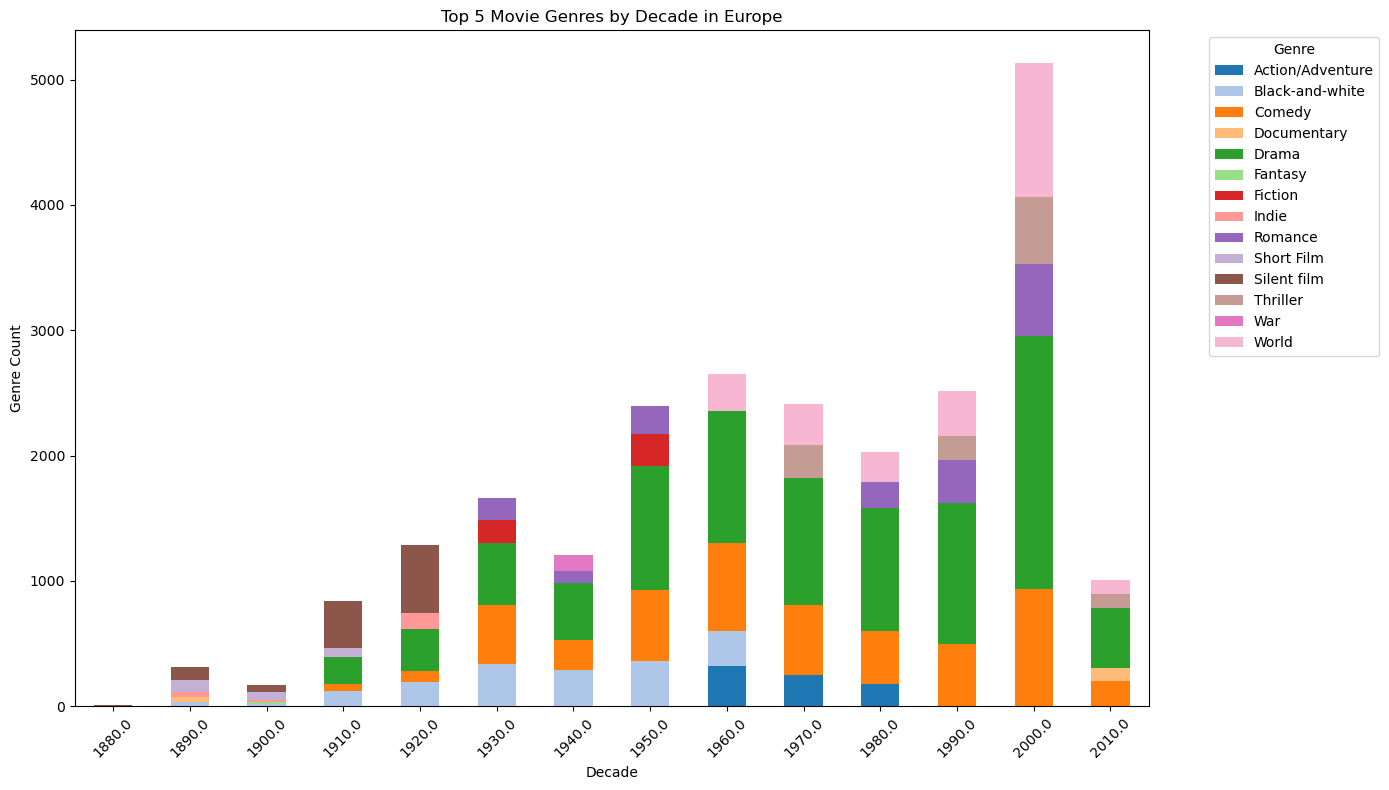

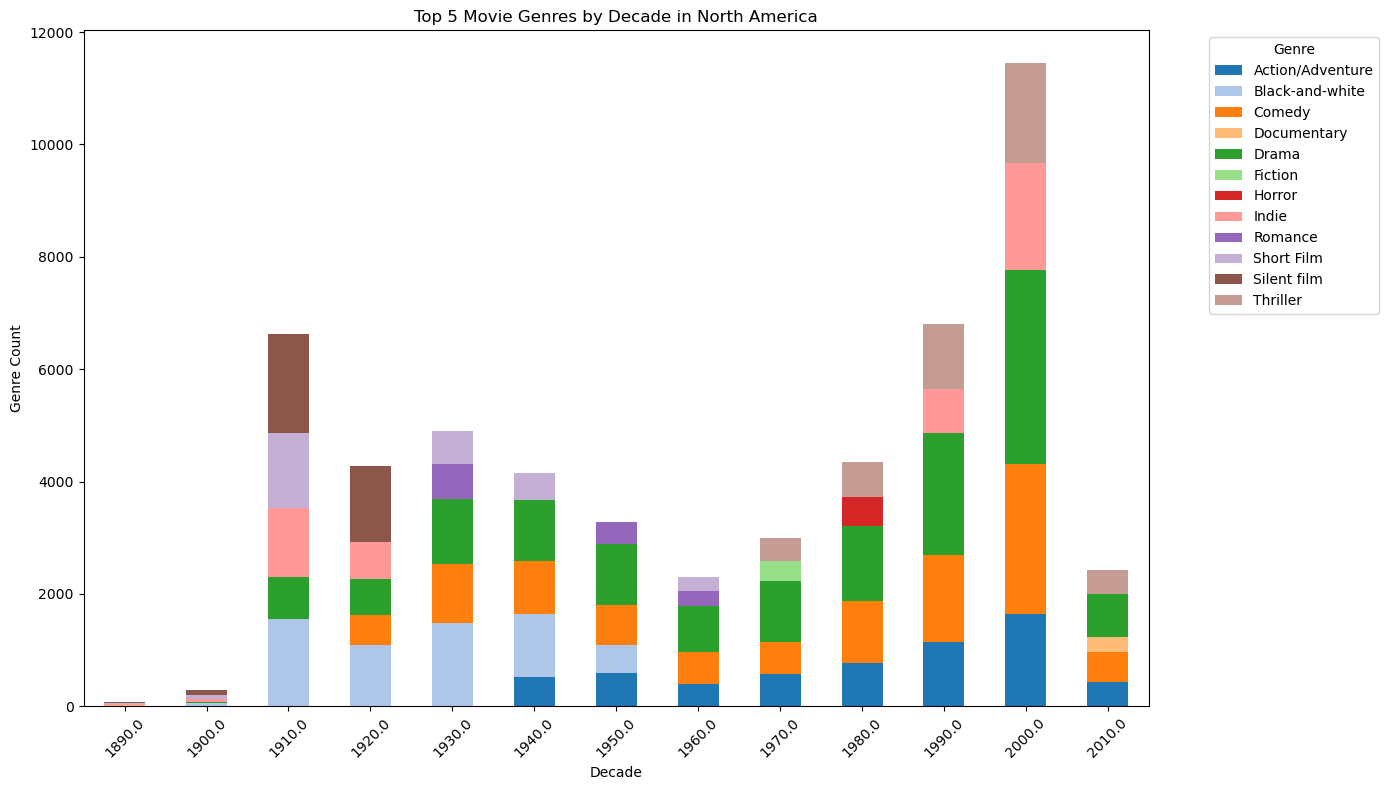

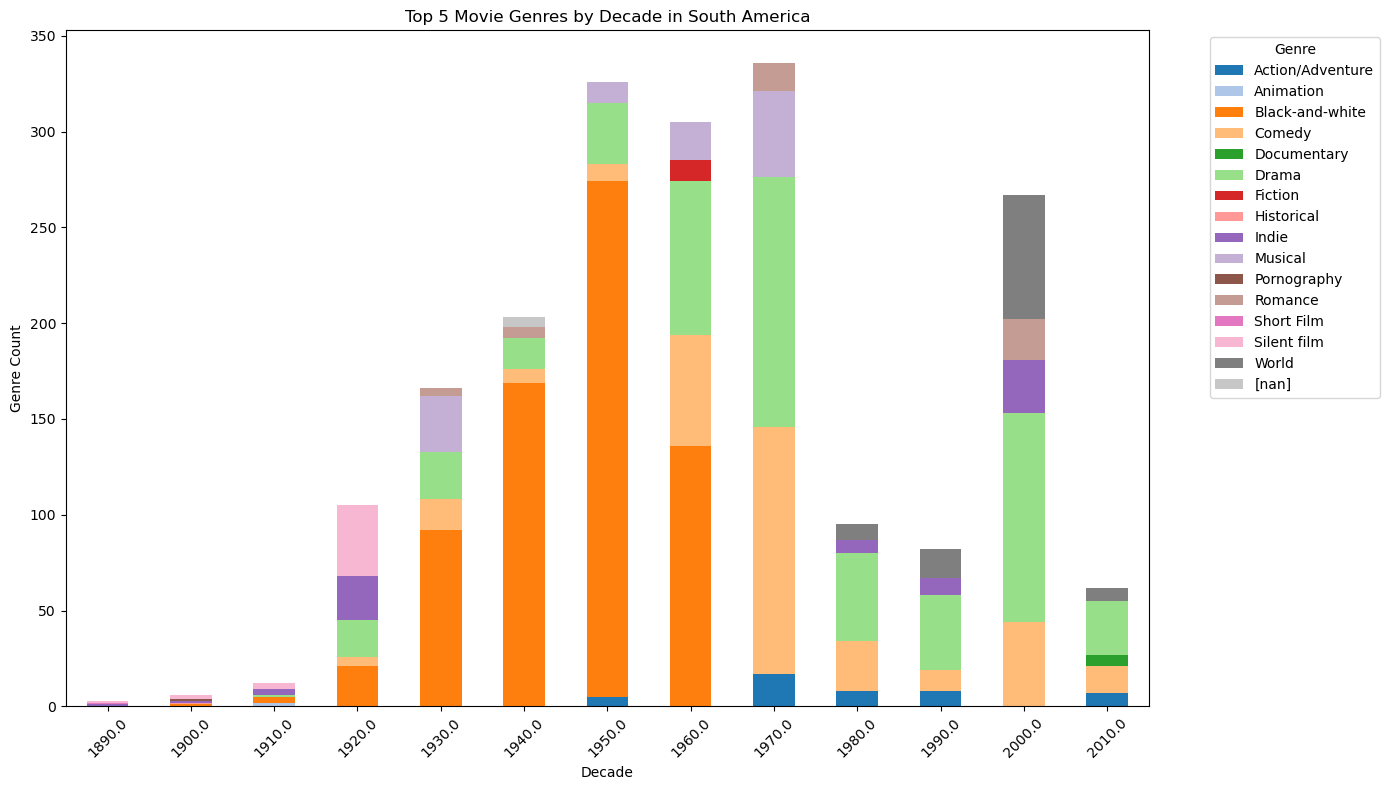

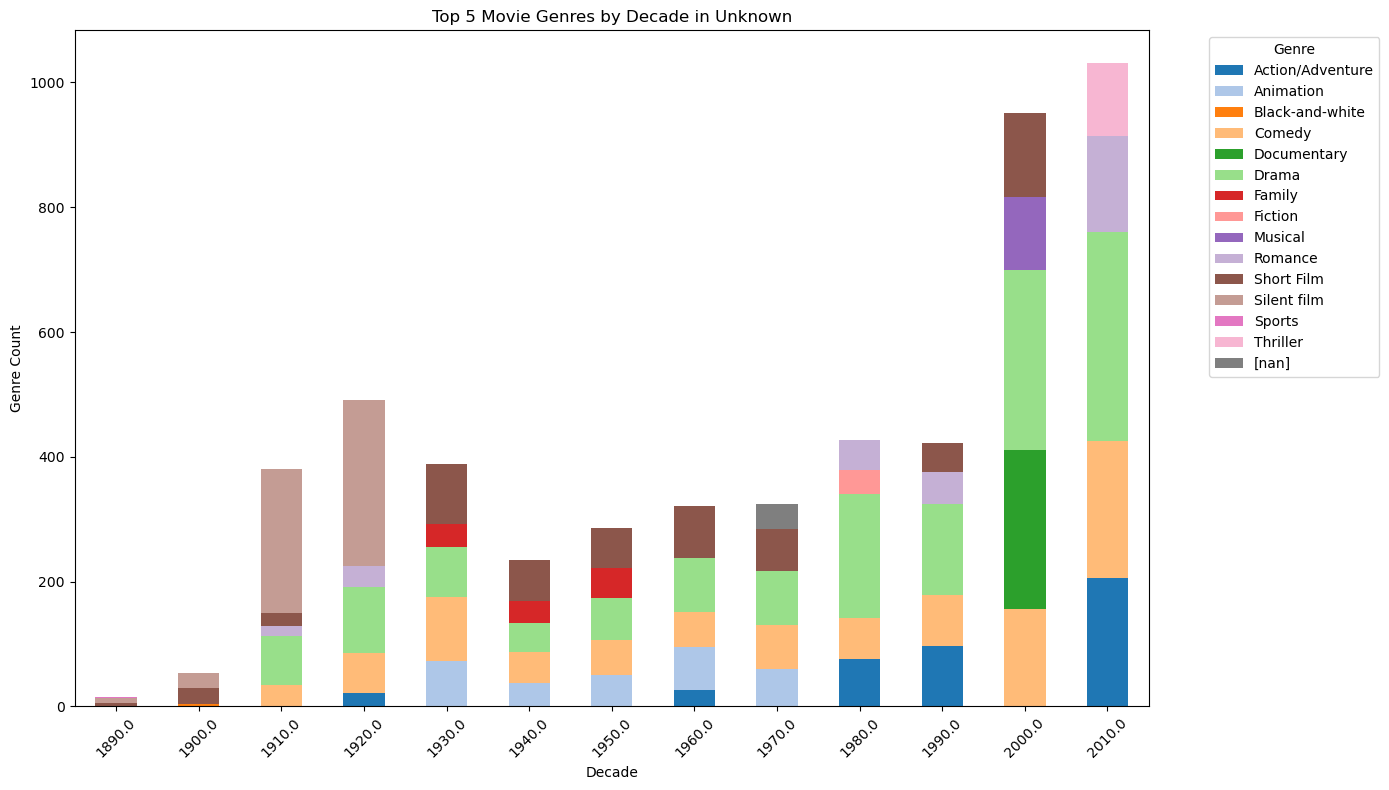

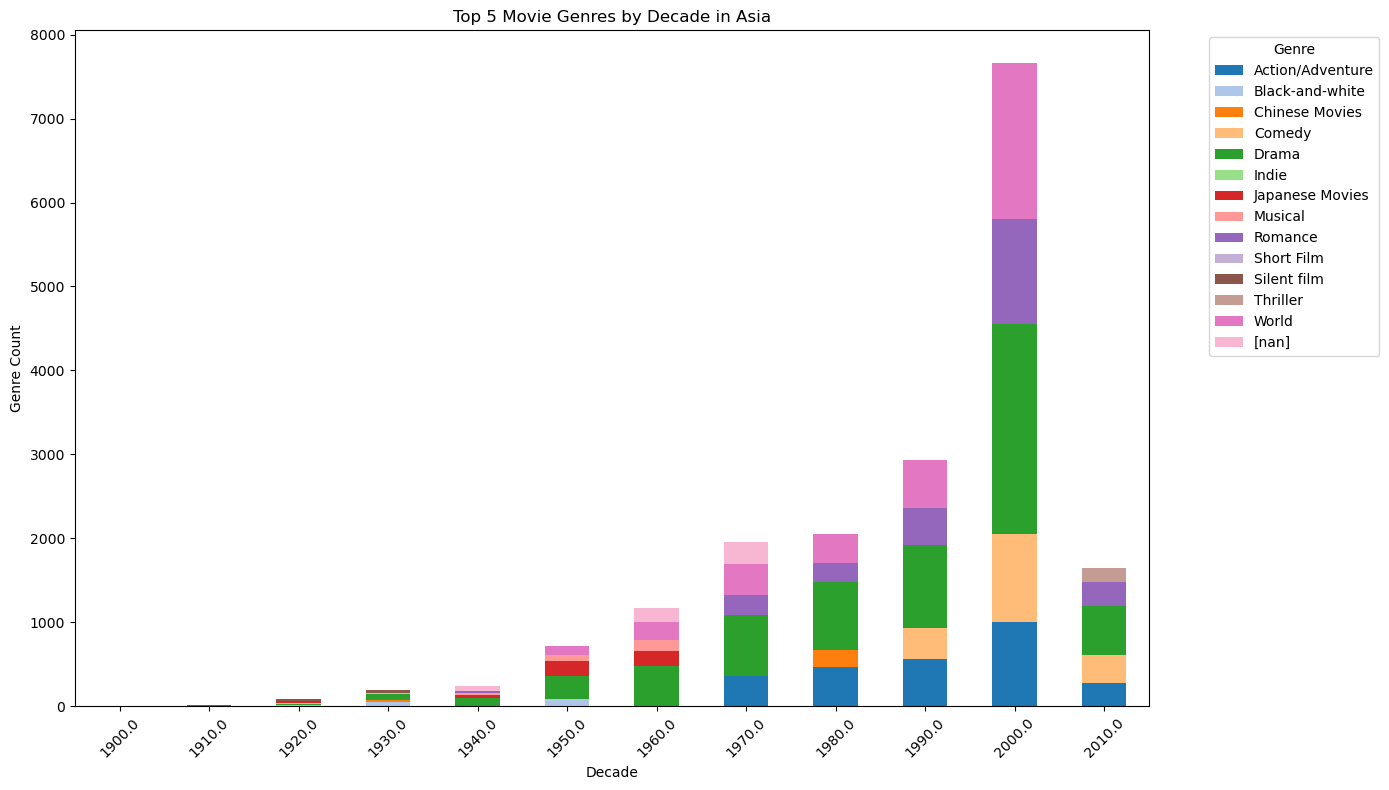

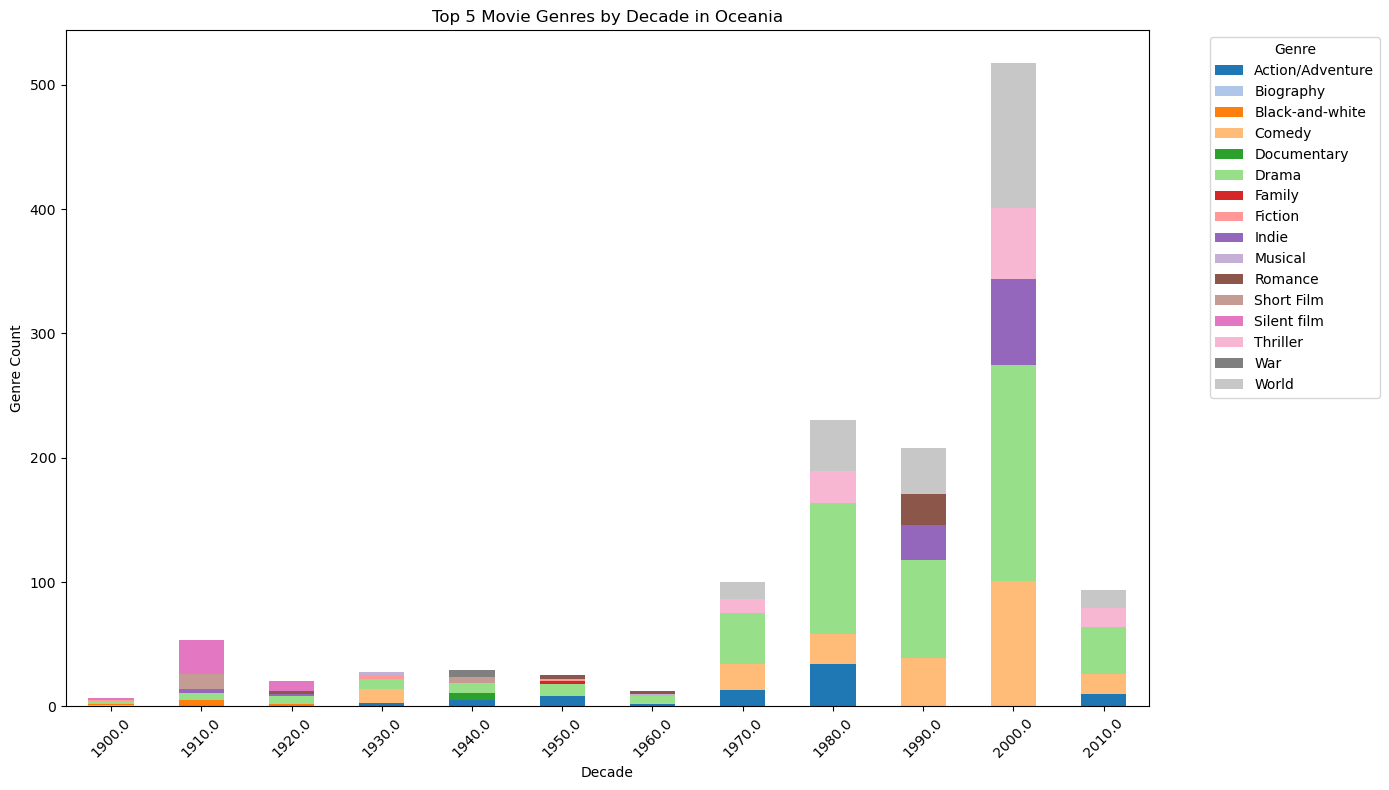

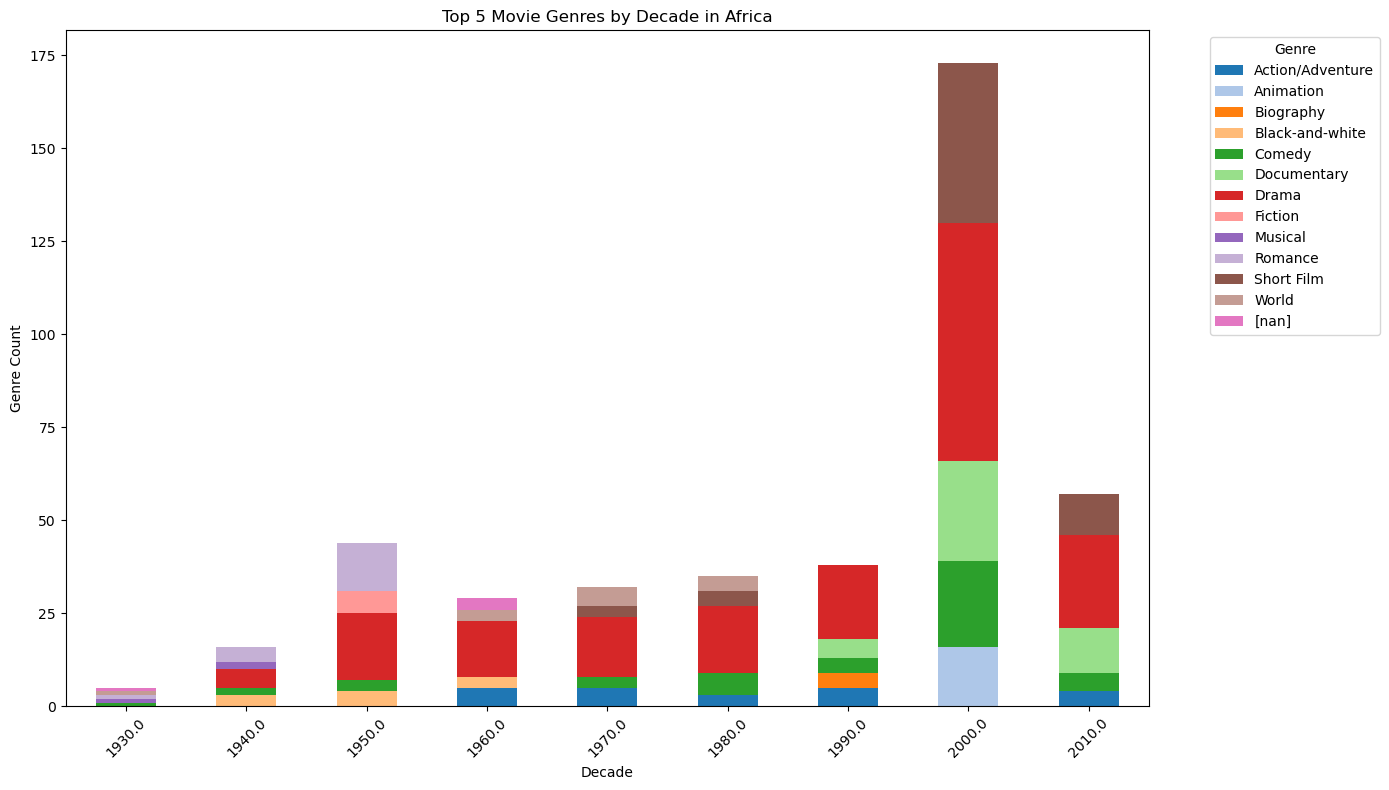

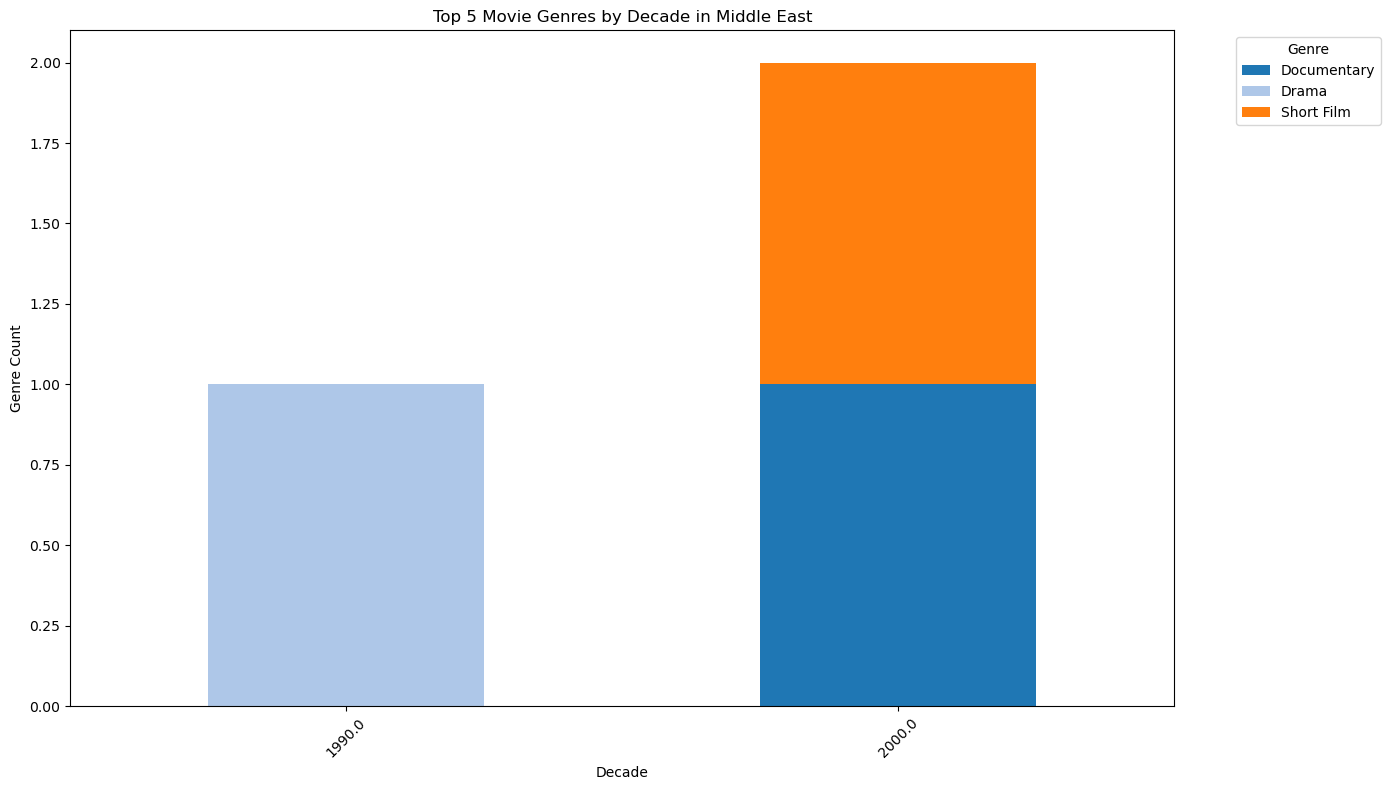

In [4]:
# Count occurence of each genre by grouping by decade, continent and genre
genre_counts = (
    df_metadata_exploded
    .groupby(['Decade', 'Movie_continent', 'Grouped_genres'])
    .size()
    .reset_index(name='Count')
)

# Find the top 5 genres per decade and continent
top_genres = (
    genre_counts
    .sort_values(['Decade', 'Movie_continent', 'Count'], ascending=[True, True, False])
    .groupby(['Decade', 'Movie_continent'])
    .head(5)
)

# Pivot the data for plotting: decade as index continents and genres as columns
top_genres_pivot = top_genres.pivot_table(
    index=['Decade', 'Movie_continent'], 
    columns='Grouped_genres', 
    values='Count', 
    fill_value=0
)

# Identify all unique genres across all continents
continents = top_genres['Movie_continent'].unique()

for continent in continents:
    plt.figure(figsize=(14, 8))
    continent_data = top_genres_pivot.xs(continent, level='Movie_continent')
    # Top genres
    unique_top_genres = continent_data.columns[continent_data.sum() > 0].tolist()

    # Color palette
    num_genres = len(unique_top_genres)
    colors = plt.cm.tab20(range(num_genres))
    color_mapping = {genre: colors[i] for i, genre in enumerate(unique_top_genres)}
    assigned_colors = [color_mapping[genre] for genre in unique_top_genres]

    ax = continent_data[unique_top_genres].plot(kind='bar', stacked=True, ax=plt.gca(), color=assigned_colors)
    handles, labels = ax.get_legend_handles_labels()
    filtered_handles = [handle for handle, label in zip(handles, labels) if label in unique_top_genres]
    filtered_labels = [label for label in labels if label in unique_top_genres]

    plt.title(f'Top 5 Movie Genres by Decade in {continent}')
    plt.xlabel('Decade')
    plt.ylabel('Genre Count')
    plt.legend(filtered_handles, filtered_labels, title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Removing the black-and-white genre as it might not be relevant for our study?

<Figure size 1400x800 with 0 Axes>

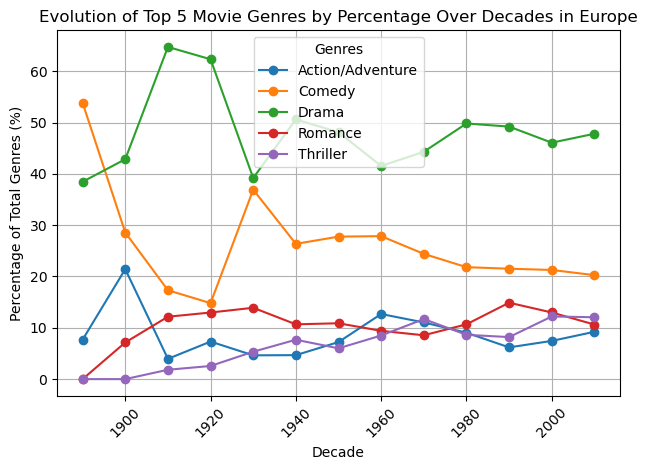

<Figure size 1400x800 with 0 Axes>

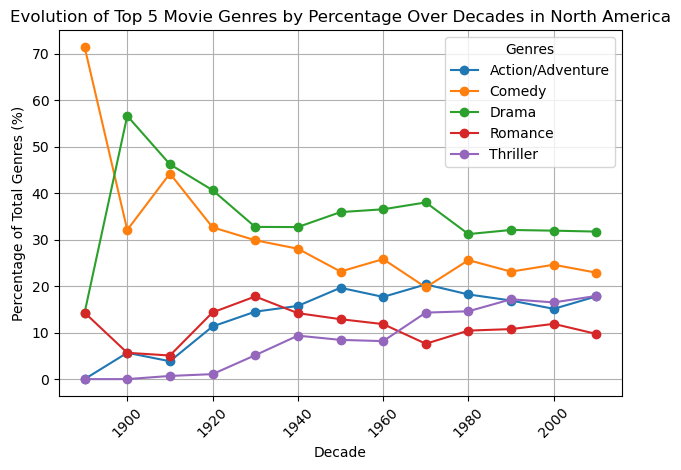

<Figure size 1400x800 with 0 Axes>

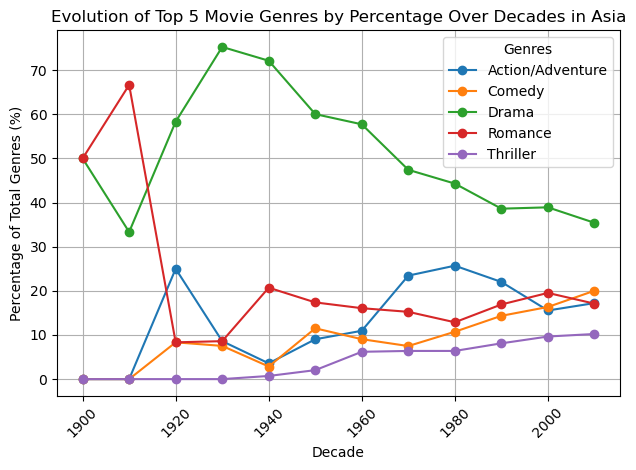

<Figure size 1400x800 with 0 Axes>

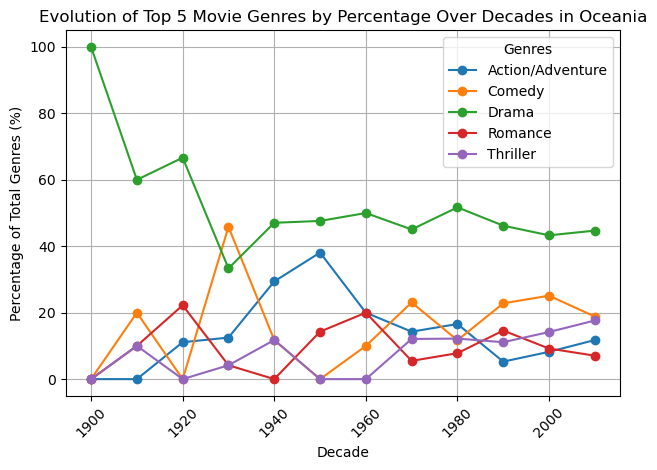

<Figure size 1400x800 with 0 Axes>

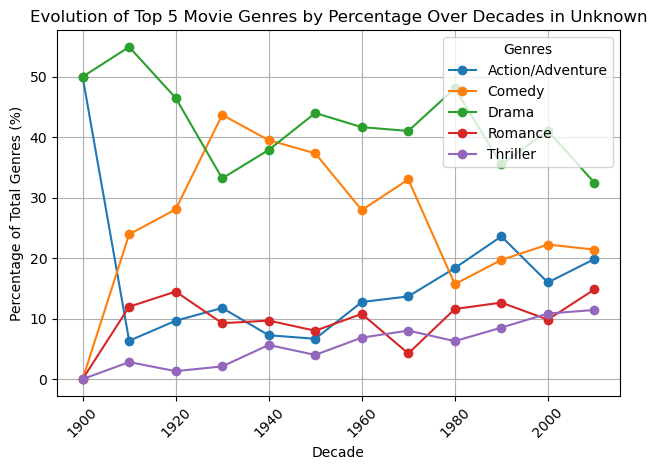

<Figure size 1400x800 with 0 Axes>

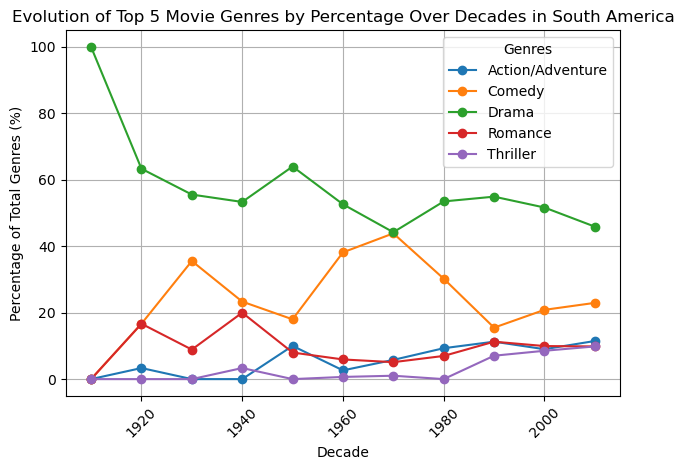

<Figure size 1400x800 with 0 Axes>

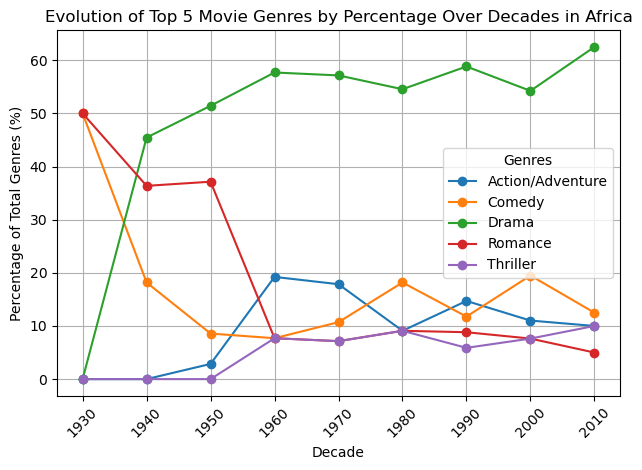

<Figure size 1400x800 with 0 Axes>

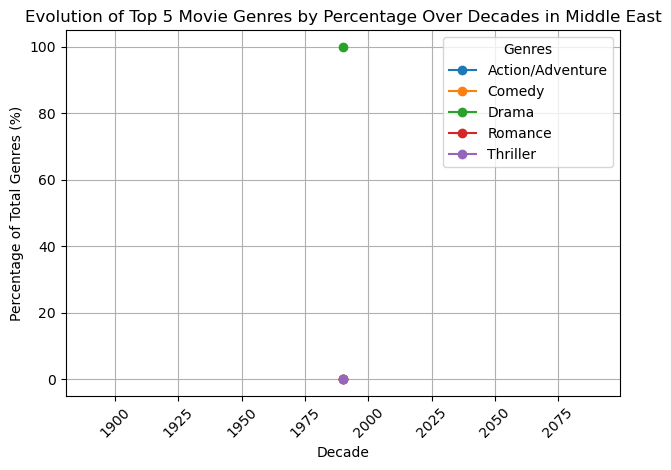

In [5]:
# Remove black-and-white genre
df_metadata_exploded = df_metadata_exploded[~df_metadata_exploded['Grouped_genres'].str.contains('Black-and-white', na=False)]
df_metadata_exploded = df_metadata_exploded[df_metadata_exploded['Decade'] >= 1800]

df_metadata_exploded['Grouped_genres'] = df_metadata_exploded['Grouped_genres'].astype(str)  # Convert all values to string

# Count occurrences of each genre by grouping by decade, continent and genre
overall_genre_counts = (
    df_metadata_exploded
    .groupby(['Decade', 'Movie_continent', 'Grouped_genres'])
    .size()
    .reset_index(name='Count')
)

# Overall top 5 genres across all continents
overall_top_genres = (
    overall_genre_counts
    .groupby('Grouped_genres')['Count']
    .sum()
    .nlargest(5)
)

top_genre_names = overall_top_genres.index.tolist()

# Keep only top genres and calculate percentages for each continent
top_genre_counts = overall_genre_counts[overall_genre_counts['Grouped_genres'].isin(top_genre_names)]

# Calculate total counts per decade and continent
total_counts_per_decade_continent = top_genre_counts.groupby(['Decade', 'Movie_continent'])['Count'].sum().reset_index()
total_counts_per_decade_continent.rename(columns={'Count': 'Total_Count'}, inplace=True)

# Merge to calculate percentage for each continent
top_genre_counts = top_genre_counts.merge(total_counts_per_decade_continent, on=['Decade', 'Movie_continent'])
top_genre_counts['Percentage'] = (top_genre_counts['Count'] / top_genre_counts['Total_Count']) * 100

# Pivot for plotting: decade and continent as indices, genres as columns
top_genre_percentages_pivot = top_genre_counts.pivot_table(
    index=['Decade', 'Movie_continent'],
    columns='Grouped_genres',
    values='Percentage',
    fill_value=0
)

continents = top_genre_counts['Movie_continent'].unique()
for continent in continents:
    plt.figure(figsize=(14, 8))
    continent_data = top_genre_percentages_pivot.xs(continent, level='Movie_continent')
    continent_data.plot(kind='line', marker='o')
    
    plt.title(f'Evolution of Top 5 Movie Genres by Percentage Over Decades in {continent}')
    plt.xlabel('Decade')
    plt.ylabel('Percentage of Total Genres (%)')
    plt.legend(title='Genres')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()
